<a href="https://colab.research.google.com/github/myazzeh/NLP-Course/blob/main/Sequence_Learning/NLP_RNN_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import necessary libraries**#

In [15]:
import pandas as pd
import numpy as np
import requests
import keras
from keras.layers import Embedding, Flatten, SimpleRNN, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.utils import pad_sequences

#**Load datasets from github and split them to input and output**#

In [2]:
train_df= pd.read_csv('https://raw.githubusercontent.com/myazzeh/NLP-Course/main/datasets/fake_news_train.csv')
test_df= pd.read_csv('https://raw.githubusercontent.com/myazzeh/NLP-Course/main/datasets/fake_news_test.csv')

In [3]:
x_train, y_train= train_df['claim_s'], train_df['fake_flag']
x_test, y_test= test_df['claim_s'], test_df['fake_flag']

#**Apply Tokenization and Align all text sequences**#
num_words parameter in Tokenizer returns the most n frequent words that will appear in the text sequences.

In [4]:
tok = Tokenizer(num_words=6620, oov_token='[UNK]')
tok.fit_on_texts (x_train)
train_seq= tok.texts_to_sequences(x_train)
test_seq= tok.texts_to_sequences(x_test)
print (f'size of vocab is {len(tok.word_index)}')

size of vocab is 6620


In [5]:
x_train[0]

'تراجع التضخم النصف سنوي في الجزائر'

In [6]:
test_seq[0:5]

[[2176, 276, 879, 718, 1518, 1, 1, 1, 6, 1, 5, 65, 2306],
 [1, 782, 4184, 1, 3103],
 [1, 6126, 1, 656, 18, 6087, 1843, 960, 39, 45, 584, 1, 8],
 [2954, 6, 242, 1248, 278, 458, 6585, 1],
 [3, 302, 1, 1, 142, 1, 4587, 1, 3, 1, 1]]

In [7]:
max_seq_leng= 10
vocab= len(tok.word_index)
embd_size= 100
train_seq= pad_sequences(train_seq, maxlen= max_seq_leng, padding ='post', truncating='post')
test_seq= pad_sequences(test_seq, maxlen= max_seq_leng, padding = 'post', truncating='post')
train_seq[0:4]

array([[  38,  131, 2212, 3830,    2,  168,    0,    0,    0,    0],
       [2213,    3,  146, 2214,   24,    0,    0,    0,    0,    0],
       [  55,    2,   12,  553, 1088, 2215,  316, 2216,    3,  836],
       [1417, 1418, 1419, 3831,    2,    9, 2217,    4,  348, 1420]],
      dtype=int32)

#**Text Classification Model 1 using one RNN layer**#

In [19]:
model= Sequential()
model.add(Embedding(input_dim= vocab , output_dim= embd_size, input_length= max_seq_leng))
model.add(Dropout(0.2))
model.add(SimpleRNN(units = embd_size, return_sequences = False))
model.add(Dense(30))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 10, 100)           662000    
                                                                 
 dropout_3 (Dropout)         (None, 10, 100)           0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense_4 (Dense)             (None, 30)                3030      
                                                                 
 dropout_4 (Dropout)         (None, 30)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 31        
                                                                 
Total params: 685161 (2.61 MB)
Trainable params: 68516

In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
result = model.fit(train_seq, y_train, epochs=10, validation_data=(test_seq, y_test) )

Epoch 1/10
100/100 [==============================] - 6s 34ms/step - loss: 0.6358 - accuracy: 0.6669 - val_loss: 0.6181 - val_accuracy: 0.6754
Epoch 2/10
100/100 [==============================] - 2s 20ms/step - loss: 0.4950 - accuracy: 0.7582 - val_loss: 0.6019 - val_accuracy: 0.6842
Epoch 3/10
100/100 [==============================] - 2s 20ms/step - loss: 0.2919 - accuracy: 0.8769 - val_loss: 0.6695 - val_accuracy: 0.6425
Epoch 4/10
100/100 [==============================] - 2s 21ms/step - loss: 0.1868 - accuracy: 0.9262 - val_loss: 0.7450 - val_accuracy: 0.6776
Epoch 5/10
100/100 [==============================] - 2s 20ms/step - loss: 0.1498 - accuracy: 0.9416 - val_loss: 0.7860 - val_accuracy: 0.6579
Epoch 6/10
100/100 [==============================] - 2s 21ms/step - loss: 0.1212 - accuracy: 0.9542 - val_loss: 0.8654 - val_accuracy: 0.6864
Epoch 7/10
100/100 [==============================] - 4s 36ms/step - loss: 0.0972 - accuracy: 0.9614 - val_loss: 0.8509 - val_accuracy: 0.6754

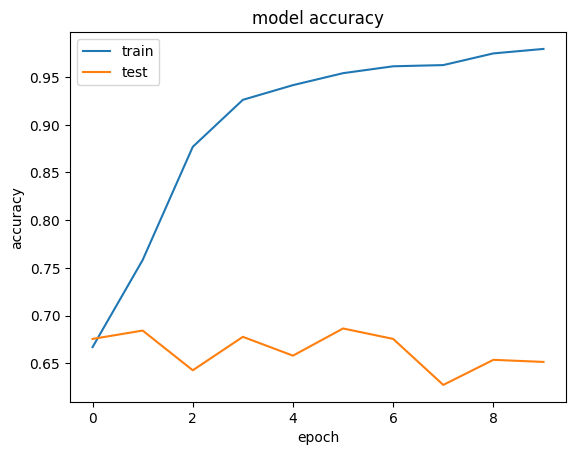

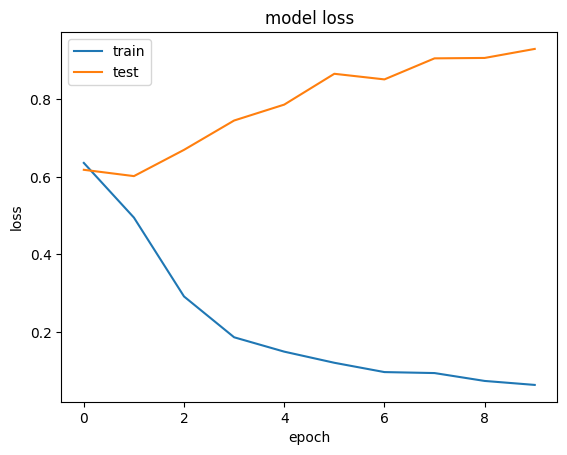

In [21]:
import matplotlib.pyplot as plt
def plot_results(trained_model, metric):
  plt.plot(result.history[metric])
  plt.plot(result.history['val_'+metric])
  plt.title('model '+ metric)
  plt.ylabel(metric)
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

plot_results(result, 'accuracy')
plot_results(result, 'loss')

In [ ]:
import tensorflow as tf

prd = model.predict(test_seq)
[1 if x>=0.5 else 0 for x in prd]

#**Text Classification Model 2 using one Bidirectional RNN layer**#

In [22]:
from keras.layers import Bidirectional, Average
model= Sequential()
model.add(Embedding(input_dim=vocab , output_dim= embd_size, input_length= max_seq_leng))
model.add(Bidirectional(SimpleRNN(units= embd_size, return_sequences=True)))
model.add(Flatten())
model.add(Dense(1))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_seq, y_train, epochs=10, validation_data=(test_seq, y_test) )

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 10, 100)           662000    
                                                                 
 bidirectional (Bidirection  (None, 10, 200)           40200     
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 2000)              0         
                                                                 
 dense_6 (Dense)             (None, 1)                 2001      
                                                                 
Total params: 704201 (2.69 MB)
Trainable params: 704201 (2.69 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
100/100 [==============================] - 8s 42ms/step - loss: 0.7517 - 

#**Text Classification Model 3 using Stacked RNN layers**#

In [23]:
from keras.layers import Bidirectional
model= Sequential()
model.add(Embedding(input_dim=vocab , output_dim= embd_size, input_length= max_seq_leng))
model.add(SimpleRNN(units= embd_size, return_sequences=True))
model.add(SimpleRNN(units= embd_size, return_sequences=True))
model.add(SimpleRNN(units= embd_size, return_sequences=False))
model.add(Dense(30))
model.add(Dense(1))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_seq, y_train, epochs=10, validation_data=(test_seq, y_test) )

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 10, 100)           662000    
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 10, 100)           20100     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 10, 100)           20100     
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense_7 (Dense)             (None, 30)                3030      
                                                                 
 dense_8 (Dense)             (None, 1)                 31        
                                                                 
Total params: 725361 (2.77 MB)
Trainable params: 72536